# Setup

In [55]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [56]:
%matplotlib inline

In [57]:
from relaxed.plot_defaults import *

In [58]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import sklearn
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [75]:
from relaxed.analysis import get_mah, fit_hearin_params, get_t_from_a, transform_diffmah, alpha_diffmah, diffmah_analysis
from relaxed.models import training_suite, prepare_datasets
from relaxed import halo_catalogs


# Data

In [40]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [54]:
ma_peak = mah_data['ma_peak']
scales = mah_data['scales']
t = get_t_from_a(scales)
t0 = get_t_from_a(1)

# Fits

In [79]:
tau_c, alpha_early, alpha_late = diffmah_analysis(ma_peak, scales)

Fitting Diffmah parameters: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.69it/s]


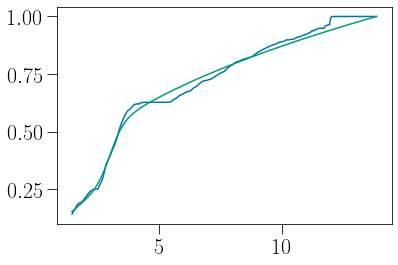

In [89]:
idx = 11
pred = (t/t0)**(alpha_diffmah(t, tau_c[idx], alpha_early[idx], alpha_late[idx]))

plt.plot(t, ma_peak[idx])
plt.plot(t, pred)